## setup

In [74]:
! pip install tensorflow numpy matplotlib pandas scikit-learn opencv-python ipywidgets

import numpy as np
import matplotlib.pyplot as plt
import os
from glob import glob
import tensorflow as tf
import keras
from keras import Input, Model
from keras.layers import Conv2D, Concatenate, Flatten, Dense, MaxPooling2D
import keras.optimizers
import sklearn
import sklearn.metrics
from PIL import Image
import time
from IPython.display import clear_output, display
import math





In [75]:
def load_images_from_folder(folder, image_size=(500, 500), numImgs = False):
    paths = sorted(glob(os.path.join(folder, '*.png')) + glob(os.path.join(folder, '*.jpg')))
    paths = sorted(paths, key=lambda x:int(os.path.basename(x).split('.')[0]))

    if numImgs:
        paths = paths[:numImgs]

    images = []
    for path in paths:
        img = keras.preprocessing.image.load_img(path, target_size=image_size)
        img = keras.preprocessing.image.img_to_array(img).astype(np.float32)
        img = img / 255.0  # Normalize to [0,1]
        images.append(img)
    return np.array(images, dtype=np.float32)


# [[distance, pitch, yaw, vehicle_id_string],...]
def load_transforms(folder, numImgs=False):
    paths = sorted(glob(os.path.join(folder, '*.npy')))
    paths = sorted(paths, key=lambda x: int(os.path.basename(x).split('.')[0]))

    if numImgs:
        paths = paths[:numImgs]


    transforms = []
    for path in paths:
        data = np.load(path) 
        transforms.append(data)
    
    return np.array(transforms)





# Create & Transform Texture

In [76]:
# texture transform helper funcs

import math


def build_affine_dta(yaw, pitch, distance, shift=None, ref_distance=10.0):
    """
    Constructs the transformation matrix following DTA Paper Eq. 5.
    Uses Foreshortening (Compression) for rotation, as described in.
    """
    # Flatten inputs
    yaw = tf.reshape(yaw, [-1])
    pitch = tf.reshape(pitch, [-1])
    distance = tf.reshape(distance, [-1])

    # Convert to radians
    yaw_r = yaw * math.pi / 180.0
    pitch_r = pitch * math.pi / 180.0

    # --- 1. SCALE (Distance) ---
    # Paper: "If the car moves further away... the texture on the screen must also shrink (higher frequency)".
    # Logic: Dist increases -> Grid covers MORE texture repetitions -> Texture looks SMALLER.
    s = distance / ref_distance

    # --- 2. ROTATION (Foreshortening) ---
    # Paper: "A square texture tile should appear as a narrower rectangle".
    # We compress the grid axis to simulate this 3D rotation.

    # YAW (Horizontal Compression):
    # Assuming the texture is applied to the SIDE of the car (Yaw=90 is optimal view).
    # sin(90) = 1.0 (Full Width). sin(0) = 0.0 (Edge on).
    # We use ABS to handle left/right sides (90 vs 270) symmetrically.
    view_factor_x = tf.abs(tf.sin(yaw_r))

    # PITCH (Vertical Compression):
    # cos(0) = 1.0 (Full Height).
    view_factor_y = tf.abs(tf.cos(pitch_r))

    # 🔥 STABILITY CLAMP (Fixes "Vertical Bars") 🔥
    # At 0 degrees, the view factor becomes 0, causing division by zero (Infinite vertical bars).
    # We clamp it to 0.2 (Max 5x compression). This keeps the texture visible but thin.
    view_factor_x = tf.maximum(view_factor_x, 0.2)
    view_factor_y = tf.maximum(view_factor_y, 0.2)

    # Calculate Scale Factors (SX, SY)
    # We DIVIDE by the factor. Smaller factor (turned away) = Larger Grid = Smaller/Squashed Texture.
    sx = s / view_factor_x
    sy = s / view_factor_y

    # --- 3. CONSTRUCT MATRIX ---
    # [ sx  0   tx ]
    # [ 0   sy  ty ]
    
    zeros = tf.zeros_like(sx)
    row1 = tf.stack([sx, zeros], axis=1)
    row2 = tf.stack([zeros, sy], axis=1)
    theta = tf.stack([row1, row2], axis=1)

    # --- 4. SHIFT (Translation) ---
    # Paper: "M_shift... translates the texture sampling grid".
    if shift is not None:
        shift = tf.reshape(shift, [-1, 2])
        # Add shift to the 3rd column
        theta = tf.concat([theta, tf.expand_dims(shift, axis=2)], axis=2)
    else:
        # Zero translation
        t = tf.zeros((tf.shape(theta)[0], 2, 1), dtype=theta.dtype)
        theta = tf.concat([theta, t], axis=2)

    return theta
    



def affine_grid(theta, out_res):
    """
    Standard Affine Grid Generator.
    theta: (B, 2, 3)
    """
    B = tf.shape(theta)[0]

    # Generate base meshgrid [-1, 1]
    x = tf.linspace(-1.0, 1.0, out_res)
    y = tf.linspace(-1.0, 1.0, out_res)
    x_t, y_t = tf.meshgrid(x, y)

    # Flatten to homogenous coordinates (x, y, 1)
    ones = tf.ones_like(x_t)
    grid = tf.stack([x_t, y_t, ones], axis=-1) # (H, W, 3)

    # Prepare for Batch Multiplication
    grid = tf.expand_dims(grid, 0)
    grid = tf.tile(grid, [B, 1, 1, 1]) # (B, H, W, 3)
    grid = tf.expand_dims(grid, -1)    # (B, H, W, 3, 1)

    # Reshape Theta: (B, 2, 3) -> (B, 1, 1, 2, 3)
    theta = tf.reshape(theta, [B, 1, 1, 2, 3])

    # Apply Transform: Grid' = Theta * Grid
    grid = tf.matmul(theta, grid)
    
    return tf.squeeze(grid, -1) # (B, H, W, 2)


def wrap_grid(grid):
    return tf.math.floormod(grid + 1.0, 2.0) - 1.0



def sample_texture(texture, grid):
    """
    Samples the texture using Wrap Mode (Toroidal Topology).
    Matches DTA Paper: "u_sample = u mod N".
    """
    B = tf.shape(grid)[0]
    Ht = tf.shape(texture)[1]
    Wt = tf.shape(texture)[2]
    
    # 1. WRAP MODE (The DTA Paper's Topology)
    # Grid is in [-inf, inf]. We need to wrap it to [-1, 1].
    # (grid + 1) / 2 moves [-1, 1] to [0, 1].
    # We rely on floormod to handle the wrapping logic later in pixel space.

    # Convert Grid [-1, 1] range to Pixel Coordinates [0, W]
    x = (grid[..., 0] + 1.0) * 0.5 * tf.cast(Wt, tf.float32)
    y = (grid[..., 1] + 1.0) * 0.5 * tf.cast(Ht, tf.float32)

    # 2. MODULO (Infinite Tiling)
    # This creates the "infinite texture plane".
    x = tf.math.floormod(x, tf.cast(Wt, tf.float32))
    y = tf.math.floormod(y, tf.cast(Ht, tf.float32))

    # 3. SAMPLING (Nearest Neighbor / Bilinear)
    # Using Nearest Neighbor for sharp pixels as requested in previous snippets
    x_idx = tf.cast(x, tf.int32)
    y_idx = tf.cast(y, tf.int32)

    # Clip for safety (though floormod should handle it)
    x_idx = tf.clip_by_value(x_idx, 0, Wt - 1)
    y_idx = tf.clip_by_value(y_idx, 0, Ht - 1)

    # Gather pixels
    # Note: Texture is (1, H, W, 3), we broadcast to B
    indices = tf.stack([y_idx, x_idx], axis=-1)
    
    # Since texture is batch 1, we can just gather from texture[0]
    # But if B > 1, we technically just want the same texture for all B.
    sampled = tf.gather_nd(texture[0], indices)

    return sampled





In [77]:
def to_float32_unit(image):
    image = np.asarray(image, dtype=np.float32)
    if image.max() > 1.0 or image.min() < 0.0:
        image /= 255.0
    return np.clip(image, 0.0, 1.0).astype(np.float32)


def generateTex(textureStyle, textureResolution):
    if textureStyle == 'noise':
        texture = tf.random.uniform(
            (1, textureResolution, textureResolution, 3),
            minval=0.0,
            maxval=1.0,
            dtype=tf.float32
        )

    elif textureStyle in ['mud', 'snow']:
        img = Image.open(f'textures/{textureStyle}.png') \
                   .convert('RGB') \
                   .resize((textureResolution, textureResolution), resample=Image.NEAREST)

        img = to_float32_unit(img)
        texture = tf.convert_to_tensor(img[None, ...], dtype=tf.float32)

    else:
        raise ValueError(f"Unsupported texture style '{textureStyle}'")

    return texture


def transformTex(texture, distance, pitch, yaw, out_res=500, shift=None):
    """
    Main pipeline function.
    """
    # 1. Build the matrix (Eq 5 from Paper)
    theta = build_affine_dta(yaw, pitch, distance, shift)
    
    # 2. Generate the sampling grid
    grid = affine_grid(theta, out_res)
    
    # 3. Sample with Wrap Mode
    return sample_texture(texture, grid)


In [78]:
def predict_and_display(model, ref, tex, intersection_mask, transformed_tex):
    #outputs = model.predict([ref, tex])
    #pred = outputs[0].astype(np.float32)

    # Overlay: only keep intersecting pixels in prediction
    #overlay_preds = np.where(intersection_mask, ref, pred)

    def _imshow(ax, image, title, cmap=None):
        ax.set_title(title)
        if cmap:
            ax.imshow(image, cmap=cmap)
        else:
            ax.imshow(np.clip(image, 0.0, 1.0))
        ax.axis("off")

    fig = plt.figure(figsize=(16, 8))

    _imshow(fig.add_subplot(2, 3, 1), ref[0], "Reference")

    _imshow(fig.add_subplot(2, 3, 2), transformed_tex, "Texture")

    _imshow(fig.add_subplot(2, 3, 3), tex[0], "Texture Mask")


    tex_overlay = np.where(intersection_mask, ref, tex)
    _imshow(fig.add_subplot(2, 3, 4), tex_overlay[0], "Texture + mask overlay")

    #_imshow(fig.add_subplot(2, 3, 5), pred, "Prediction no overlay")

    #_imshow(fig.add_subplot(2, 3, 6), overlay_preds[0], "Prediction + mask overlay")

    plt.tight_layout()
    plt.show()



# Playground

In [22]:
dataset_folder = 'sample_dataset'
numImgsToLoad = 100
sample_references = load_images_from_folder(f"{dataset_folder}/reference", numImgs = numImgsToLoad)
sample_masks = load_images_from_folder(f"{dataset_folder}/masks", numImgs = numImgsToLoad)
sample_overlays = load_images_from_folder(f"{dataset_folder}/overlays", numImgs = numImgsToLoad)
sample_transforms = load_transforms(f"{dataset_folder}/transforms", numImgs = numImgsToLoad)


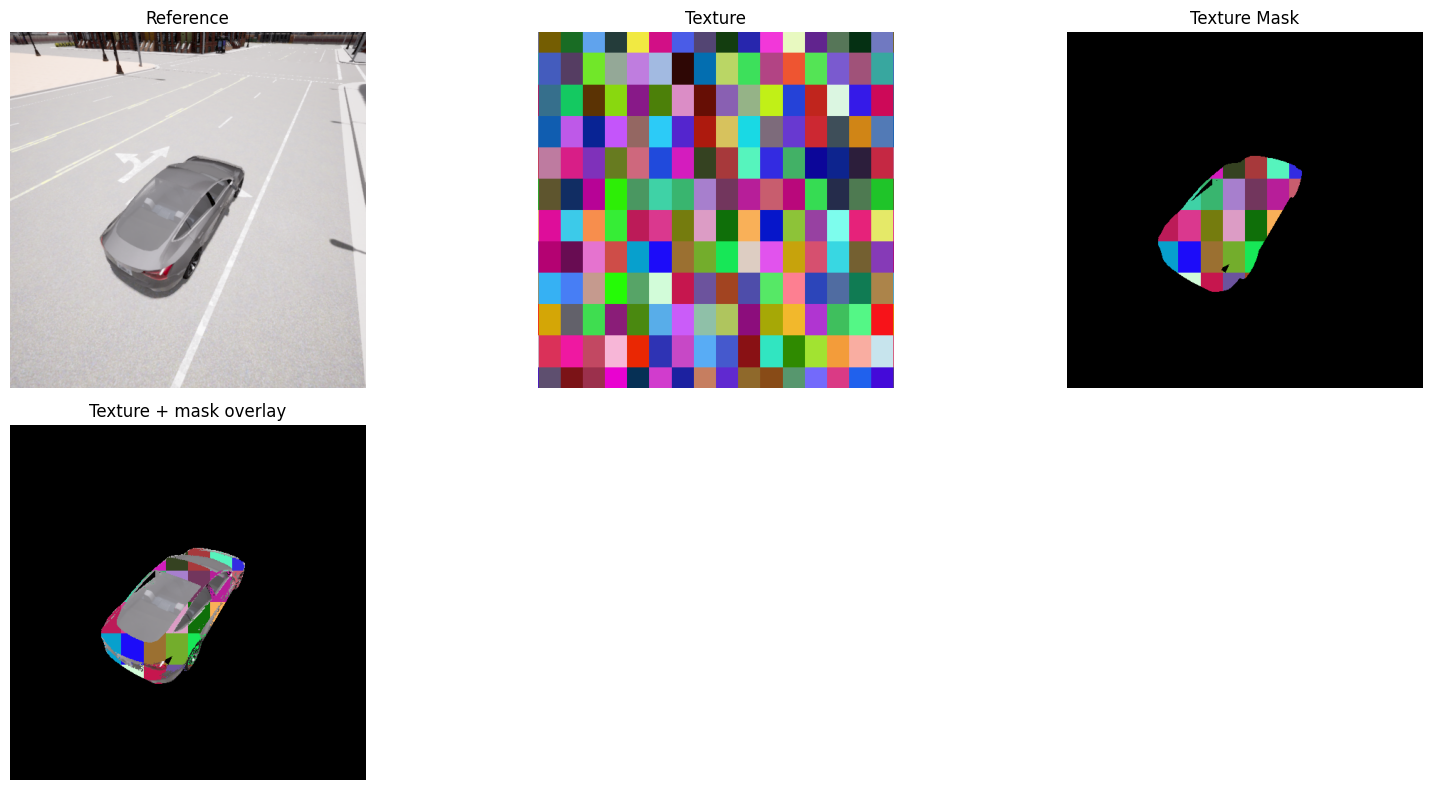

In [79]:

modelChoice = 'k3_100epch_wo_custom_loss_model.h5'
textureStyle = 'noise'
textureResolution = 16


model = keras.models.load_model(f'models/{modelChoice}', compile=False)

texture = generateTex(
    textureStyle,
    textureResolution
)

print(sample_transforms[14])




for i in range(len(sample_references)):
    sampleNo = i

    ref_img = sample_references[sampleNo]
    mask_img = sample_masks[sampleNo]
    overlay_img = sample_overlays[sampleNo]
    transforms = sample_transforms[sampleNo]


    #distance tex size backwards
    if int(transforms[0])!=5: # int(transforms[1])!=30 or int(transforms[2])!=90 
        continue


    # transforms = [[distance, pitch, yaw, vehicle_id_string],...]
    distance = tf.constant([float(transforms[0])], dtype=tf.float32)
    pitch = tf.constant([float(transforms[1])], dtype=tf.float32)
    yaw = tf.constant([float(transforms[2])], dtype=tf.float32)

    transformed_tex = transformTex(texture, distance, pitch, yaw, out_res=500)

    # Apply texture to masked regions
    mask = tf.cast(
        tf.reduce_any(mask_img > 0.01, axis=-1, keepdims=True),
        tf.float32
    )
    texture_mask = transformed_tex * mask

    refInput = np.expand_dims(ref_img, axis=0).astype(np.float32)  # shape: (1, 500, 500, 3)
    texInput = texture_mask.numpy().astype(np.float32)
    feature_mask = np.expand_dims(overlay_img, axis=0).astype(np.float32)  # shape: (1, 500, 500, 3)

    predict_and_display(model, refInput, texInput, feature_mask, transformed_tex[0].numpy())

    time.sleep(0.025)
    clear_output(wait=True)
